In [2]:
import pandas as pd
from nltk.tokenize import sent_tokenize
import os
from pathlib import Path
import re
import spacy
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

spacy.cli.download("en_core_web_sm")
# python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 1.3 MB/s eta 0:00:00m eta 0:00:010:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])
nlp.add_pipe("sentencizer")

In [4]:
DATA_DIR = Path.cwd() / "aajonus_data"

DF_DIR = Path.cwd() / "aajonus_saved_dfs"
DF_DIR.mkdir(exist_ok=True)

df_path = DF_DIR / "dataframe.csv"

# Conditional that checks whether we saved the dfs as csv files
# If yes, then reinitialise these as dfs
# If not, then create the dfs and save them in csv format for next run
if df_path.exists():
    print("Loading dataset from CSV...")
    df = pd.read_csv(df_path)
else:
    data = []

    for filename in os.listdir(DATA_DIR):
        if filename.endswith(".txt"):
            print(filename)

            # Create the filepath
            file_path = DATA_DIR / filename
            with open(file_path, "r", encoding="utf-8") as file:
                content = file.read()
                # Use spaCy to tokenize the content into sentences
                doc = nlp(content)
                sentences = [sent.text.strip() for sent in doc.sents]
                # Append each sentence to your data list, along with the filename
                for sentence in sentences:
                    data.append({"filename": filename, "sentence": sentence})


    df = pd.DataFrame(data)

    # Save DF
    df.to_csv(df_path, index=False)

print(df.head())

Loading dataset from CSV...
                                            filename  \
0  Needles_Of_Disease_and_Death_Continue_In_The_N...   
1  Needles_Of_Disease_and_Death_Continue_In_The_N...   
2  Needles_Of_Disease_and_Death_Continue_In_The_N...   
3  Needles_Of_Disease_and_Death_Continue_In_The_N...   
4  Needles_Of_Disease_and_Death_Continue_In_The_N...   

                                            sentence  
0  On Halloween, I received the most alarming ter...  
1  I received it\nin a letter from Care2 organiza...  
2  Most of us have\nnever witnessed the crippling...  
3  Polio is still endemic in three of the world's...  
4  This is the scary truth: levels of polio are a...  


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ethancavill/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


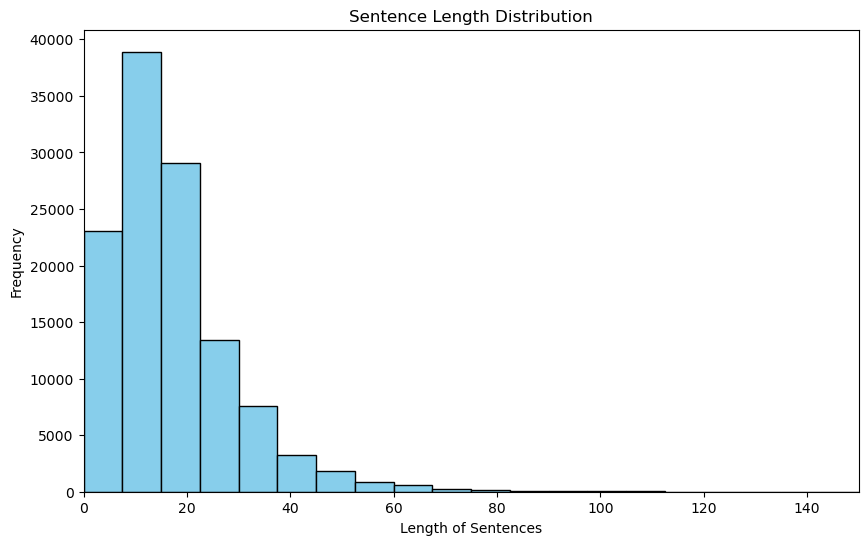

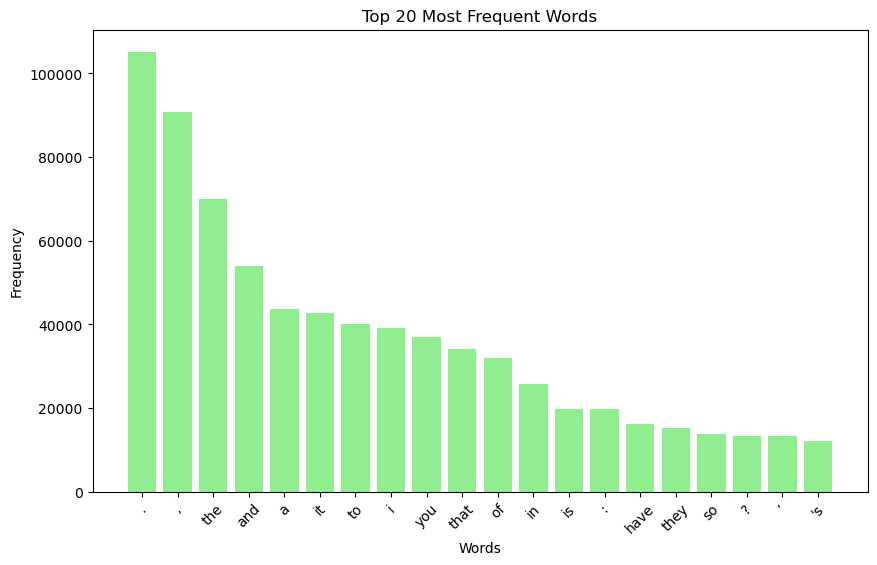

Top 5 Bigrams:       Bigram  Frequency
0     (a, :)       8217
1  (in, the)       7073
2   (,, and)       6551
3     (q, :)       6512
4     (,, i)       5928


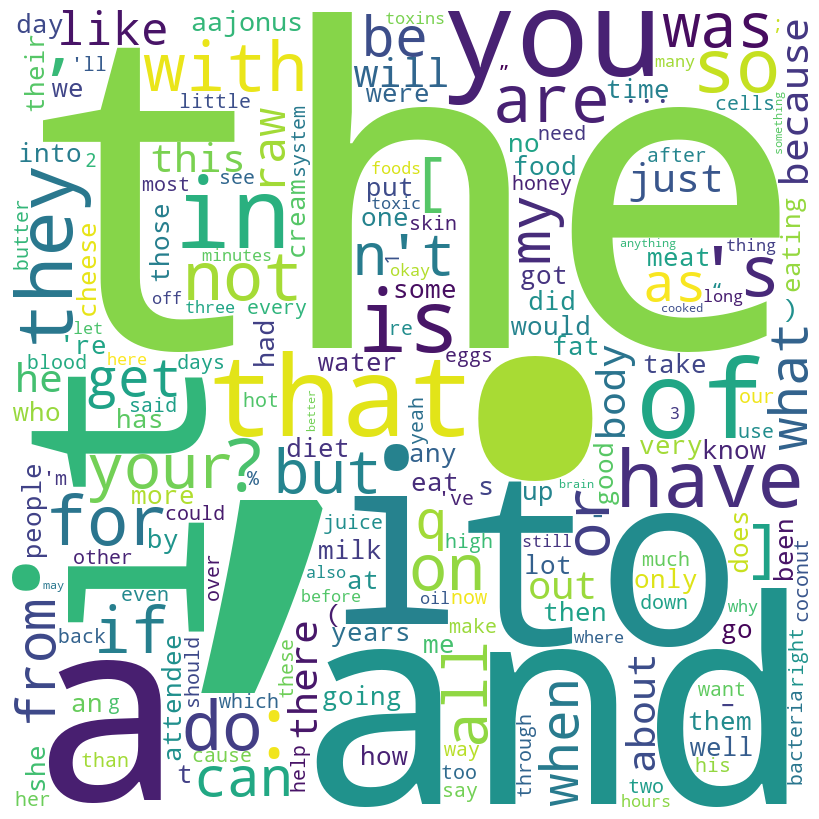

In [5]:
# EDA Cell
import matplotlib.pyplot as plt
from collections import Counter
import nltk
nltk.download('punkt')
from nltk.util import ngrams
from wordcloud import WordCloud

# Basic Statistical Analysis

# Ensure all sentences are strings
df['sentence'] = df['sentence'].astype(str)

# 1. Sentence Length Distribution
df['sentence_length'] = df['sentence'].apply(lambda x: len(nltk.word_tokenize(x)))

plt.figure(figsize=(10, 6))
plt.hist(df['sentence_length'], bins=20, color='skyblue', edgecolor='black', range=[0, 150])
plt.title('Sentence Length Distribution')
plt.xlabel('Length of Sentences')
plt.ylabel('Frequency')
plt.xlim(0, 150)
plt.show()

# 2. Word Count Frequency
word_counts = Counter()
df['sentence'].apply(lambda x: word_counts.update(nltk.word_tokenize(x.lower())))
most_common_words = pd.DataFrame(word_counts.most_common(20), columns=['Word', 'Frequency'])

plt.figure(figsize=(10, 6))
plt.bar(most_common_words['Word'], most_common_words['Frequency'], color='lightgreen')
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# 3. Common Phrases and N-grams
bigram_counts = Counter()
df['sentence'].apply(lambda x: bigram_counts.update(ngrams(nltk.word_tokenize(x.lower()), 2)))
most_common_bigrams = pd.DataFrame(bigram_counts.most_common(20), columns=['Bigram', 'Frequency'])

# Displaying the top 5 for simplicity
print("Top 5 Bigrams:", most_common_bigrams.head())

# 4. Word Cloud for unigrams
wordcloud = WordCloud(
    width = 800, 
    height = 800, 
    background_color ='white', 
    min_font_size = 10
    ).generate_from_frequencies(word_counts)

# Plotting the WordCloud
plt.figure(figsize=(8, 8), facecolor=None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad=0) 
plt.show()

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

JOBLIB_DIR = Path.cwd() / "aajonus_joblibs"
JOBLIB_DIR.mkdir(exist_ok=True)

vectorizer_path = JOBLIB_DIR / 'tfidf_vectorizer.joblib'
matrix_path = JOBLIB_DIR / 'tfidf_matrix.joblib'

max_df = 0.85
min_df = 0.0
ngram_range = (2, 3)
version=5

def custom_tokenizer(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc]

# Check if parameters have changed and files exist
params_changed = False
if vectorizer_path.exists():
    existing_vectorizer = joblib.load(vectorizer_path)
    if (existing_vectorizer.max_df != max_df or 
        existing_vectorizer.min_df != min_df or 
        existing_vectorizer.ngram_range != ngram_range):
        params_changed = True
        os.remove(vectorizer_path)
        os.remove(matrix_path)

if not matrix_path.exists() or params_changed:
    print("Fitting TF-IDF vectorizer to the dataset...")
    vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=max_df, min_df=min_df, ngram_range=ngram_range)
    tfidf_matrix = vectorizer.fit_transform(df['sentence'])
    joblib.dump(vectorizer, vectorizer_path)
    joblib.dump(tfidf_matrix, matrix_path)
else:
    print("Loading fitted TF-IDF vectorizer and matrix dataset...")
    vectorizer = joblib.load(vectorizer_path)
    tfidf_matrix = joblib.load(matrix_path)

Fitting TF-IDF vectorizer to the dataset...


/Users/ethancavill/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [7]:
from sklearn.metrics.pairwise import cosine_similarity

def search(query, vectorizer, tfidf_matrix, df):
    query_vector = vectorizer.transform([query])  # Preprocessing is handled by vectorizer
    similarities = cosine_similarity(query_vector, tfidf_matrix)
    top_indices = similarities.argsort()[0][-20:]

    # Retrieve the corresponding rows from the DataFrame
    top_docs = df.iloc[top_indices]
    top_scores = similarities[0][top_indices]

    return top_docs, top_scores

In [8]:
import time

test_set_columns=["Query", "Result", "Cosine", "Filename", "Date", "Max DF", "Min DF", "Ngram Range"]

def search_main(query, vectorizer, tfidf_matrix, df, max_df, min_df, ngram_range, test_set):
    top_docs, top_scores = search(query, vectorizer, tfidf_matrix, df)
    
    if top_docs.empty:
        print("No documents found for this query.")
        return test_set

    new_rows = []
    for (index, row), score in zip(top_docs.iterrows(), top_scores):
        new_row = {
            "Query": query,
            "Result": row['sentence'],
            "Cosine": score,
            "Filename": row['filename'],
            "Date": pd.Timestamp('now'),
            "Max DF": max_df,
            "Min DF": min_df,
            "Ngram Range": ngram_range
        }
        new_rows.append(new_row)
    
    # Create a DataFrame from the new_rows list
    new_rows_df = pd.DataFrame(new_rows)
    
    # Append the new_rows_df to the test_set
    test_set = pd.concat([test_set, new_rows_df], ignore_index=True)
    
    return test_set

In [9]:
def generate_test_set_from_queries(query_file_path, vectorizer, tfidf_matrix, df, max_df, min_df, ngram_range):
    test_set = pd.DataFrame(columns=test_set_columns)
    with open(query_file_path, 'r') as file:
        queries = file.read().splitlines()
    
    for query in queries:
        test_set = search_main(query, vectorizer, tfidf_matrix, df, max_df, min_df, ngram_range, test_set)
    
    return test_set

TEST_SET_DIR = Path.cwd() / "aajonus_test_sets"
TEST_SET_DIR.mkdir(exist_ok=True)
test_set_path = TEST_SET_DIR / f"test_set_v{version}.csv"
query_file_path = TEST_SET_DIR / "queries.txt"

test_set = generate_test_set_from_queries(query_file_path, vectorizer, tfidf_matrix, df, max_df, min_df, ngram_range)

test_set.to_csv(test_set_path, index=False)

In [10]:
import re

def normalize_sentence(sentence):
    # Function to normalize sentences for comparison
    # Remove punctuation and extra spaces, and convert to lowercase
    return re.sub(r'\s+', ' ', re.sub(r'[^\w\s]', '', sentence)).strip().lower()

def compute_evaluations(test_set, relevant_results):
    evaluation_data = []

    for query_group in relevant_results['Query'].unique():
        grouped_queries = query_group.split(',')
        relevant_set = set([normalize_sentence(sentence) for sentence in relevant_results[relevant_results['Query'] == query_group]['Result']])
        
        total_hits = 0
        matching_sentences = []

        for query in grouped_queries:
            query = query.strip()
            query_results = test_set[test_set['Query'] == query]['Result'].apply(normalize_sentence)

            # Count matching sentences, including duplicates
            for sentence in query_results:
                if sentence in relevant_set:
                    total_hits += 1
                    matching_sentences.append(sentence)

        evaluation_data.append({
            'Query Group': query_group,
            'Total Hits': total_hits,
            'Matching Sentences': ', '.join(matching_sentences)
        })
    
    eval_df = pd.DataFrame(evaluation_data)
    
    return eval_df

EVAL_DIR = Path.cwd() / "aajonus_evaluations"
EVAL_DIR.mkdir(exist_ok=True)

relevant_results_path = TEST_SET_DIR / "relevant_query_results.csv"
relevant_results = pd.read_csv(relevant_results_path)

test_set_path = TEST_SET_DIR / f"test_set_v{version}.csv"
test_set = pd.read_csv(test_set_path)

eval_df = compute_evaluations(test_set, relevant_results)
eval_path = EVAL_DIR / f"evaluation_v{version}.csv"
eval_df.to_csv(eval_path, index=False)

print(eval_df.head())

                                         Query Group  Total Hits  \
0  Is salt unhealthy, Salt damages cells,\n Why i...           0   
1    What are signs of intelligence, Genius and diet           1   
2                        How to gain weight quickly            0   
3     What is arthritis, What is arthritis caused by           0   
4          What does high meat do, Why eat high meat           4   

                                  Matching Sentences  
0                                                     
1             cynicism is not a sign of intelligence  
2                                                     
3                                                     
4  i started doing high meat and was wondering ho...  
